Implementation of : http://cs229.stanford.edu/proj2012/ShenJiangZhang-StockMarketForecastingusingMachineLearningAlgorithms.pdf

In [96]:
import numpy as np
import pandas as pd
import copy
from datetime import datetime, timedelta
from dateutil.relativedelta import *

from __future__ import print_function

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15,6)

import pyfolio as pf

# Data Preprocessing

In [2]:
input_data_path = 'Data/'

In [3]:
analysis_symbol = "NSEI"
available_col_list = ['N225', 'HSI', 'AXJO', 'AUD', 'JPY', 'HKD', 'GC', 'SI', 'PL', 'CB']
unavailable_col_list = ['NSEI', 'GDAXI', 'IXIC', 'DJI', 'GSPC', 'FTSE', 'EUR', 'GBP', 'INR']

In [4]:
# Required as format of group is different from other group as obtained from several different sources.

nifty50_fnm = [('NSEI', '^NSEI.csv')]
indices_fnm1 = [('IXIC', '^IXIC.csv'), ('DJI', '^DJI.csv'), ('GSPC', '^GSPC.csv'),
               ('N225', '^N225.csv'), ('HSI', '^HSI.csv'), ('GDAXI', '^GDAXI.csv'),
               ('AXJO', '^AXJO.csv')]
indices_fnm2 = [('FTSE', '^FTSE.csv')]
currency_fnm = [('EUR', 'EUR_USD.csv'), ('AUD', 'AUD_USD.csv'), ('JPY', 'USD_JPY.csv'),
                ('HKD', 'USD_HKD.csv'), ('GBP', 'GBP_USD.csv'), ('INR', 'USD_INR.csv')]
commodity_fnm = [('GC', 'gc.f.csv'), ('SI', 'si.f.csv'), ('PL', 'pl.f.csv'), ('CB', 'cb.f.csv')]

In [5]:
def load_data(nm, fnm, date_format, req_col_nm):
    df = pd.read_csv(input_data_path + fnm)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df[nm] = pd.to_numeric(df[req_col_nm], errors='coerce')
    return(df[nm])

In [47]:
df_list = []
start_date = datetime(2001,1,3).date()
# end_date = datetime(2012,10,25).date()
end_date = datetime(2018,3,29).date()

for nm,fnm in nifty50_fnm:
    df = load_data(nm, fnm, '%d %b %Y', 'Close')
    df_list.append(df)
for nm,fnm in indices_fnm1:
    df = load_data(nm, fnm, '%Y-%m-%d', 'Adj Close')
    df_list.append(df)
for nm,fnm in indices_fnm2:
    df = load_data(nm, fnm, '%b %d %Y', 'Price')
    df_list.append(df)
for nm,fnm in currency_fnm:
    df = load_data(nm, fnm, '%b %d, %Y', 'Price')
    df_list.append(df)
for nm,fnm in commodity_fnm:
    df = load_data(nm, fnm, '%Y-%m-%d', 'Close')
    df_list.append(df)
    
df = pd.concat(df_list, axis=1)
df = df.reset_index()
df = df[(df['Date']>=start_date) & (df['Date']<=end_date)] # Selecting date range where all the variable are available
df.set_index('Date', inplace=True)
df.tail(50)

,NSEI,IXIC,DJI,GSPC,N225,HSI,GDAXI,AXJO,FTSE,EUR,AUD,JPY,HKD,GBP,INR,GC,SI,PL,CB
Date,,,,,,,,,,,,,,,,,,,
2018-01-19,10894.70,7336.379883,26071.720703,2810.300049,23808.060547,32254.890625,13434.450195,6005.799805,7730.79,1.2222,0.7993,110.78,7.8166,1.3852,63.830,1333.1,1703.6,1020.1,68.61
2018-01-22,10966.20,7408.029785,26214.599609,2832.969971,23816.330078,32393.410156,13463.690430,5991.899902,7715.44,1.2262,0.8017,110.92,7.8183,1.3987,63.890,1331.9,1698.9,996.8,69.03
2018-01-23,11083.70,7460.290039,26210.810547,2839.129883,24124.150391,32930.699219,13559.599609,6037.000000,7731.83,1.2299,0.7998,110.31,7.8189,1.4001,63.760,1336.7,1691.3,1007.8,69.96
2018-01-24,11086.00,7415.060059,26252.119141,2837.540039,23940.779297,32958.691406,13414.740234,6054.700195,7643.43,1.2408,0.8062,109.22,7.8183,1.4243,63.660,1356.3,1748.9,1015.8,70.53
2018-01-25,11069.65,7411.160156,26392.789063,2839.250000,23669.490234,32654.449219,13298.360352,6050.000000,7615.84,1.2396,0.8031,109.41,7.8178,1.4146,63.515,1362.9,1761.5,1032.1,70.42
2018-01-26,NaN,7505.770020,26616.710938,2872.870117,23631.880859,33154.121094,13340.169922,NaN,7665.54,1.2421,0.8112,108.72,7.8172,1.4170,63.590,1352.1,1744.1,1018.4,70.52
2018-01-29,11130.40,7466.509766,26439.480469,2853.530029,23629.339844,32966.890625,13324.480469,6075.399902,7671.53,1.2383,0.8095,108.95,7.8178,1.4075,63.600,1340.3,1712.7,1012.7,69.20
2018-01-30,11049.65,7402.479980,26076.890625,2822.429932,23291.970703,32607.289063,13197.709961,6022.799805,7587.98,1.2402,0.8083,108.78,7.8208,1.4146,63.690,1335.4,1705.8,1001.8,68.52
2018-01-31,11027.70,7411.479980,26149.390625,2823.810059,23098.289063,32887.269531,13189.480469,6037.700195,7533.55,1.2421,0.8055,109.19,7.8228,1.4192,63.550,1339.0,1724.1,1004.3,68.89


#### Analysing Null values and filling with previous value whenever possible

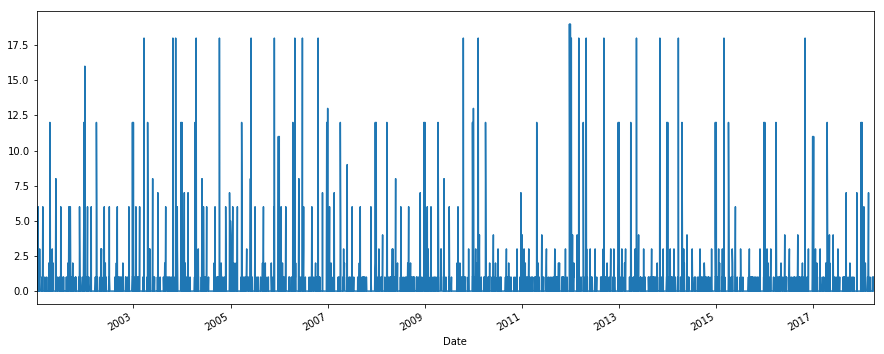

In [48]:
df.isnull().sum(axis=1).plot()

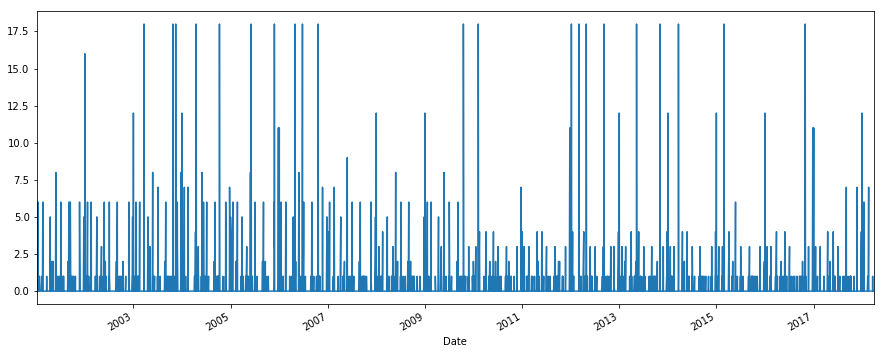

In [49]:
df1 = df.dropna(subset=[analysis_symbol])
df1.isnull().sum(axis=1).plot()

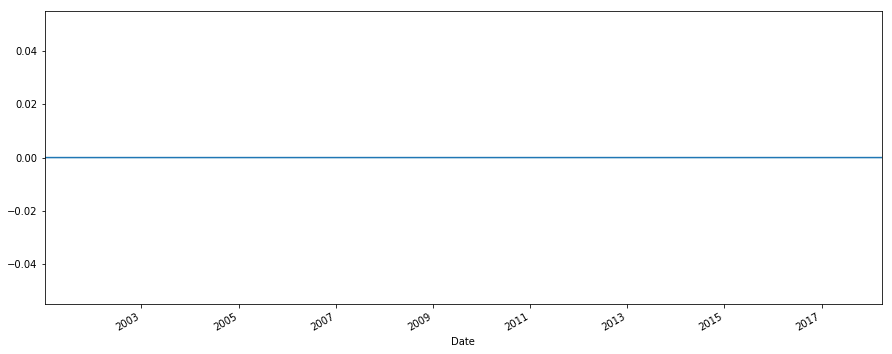

In [50]:
df2 = df1.fillna(method='ffill')
df2.dropna(inplace=True)
df2.isnull().sum(axis=1).plot()

# Temporal Correlation with Indices and Commodities

In [51]:
def delta_day_return(df, delta):
# Calculates moving returns over last delta days
    dfr = pd.DataFrame()
    for col in df.columns:
        dfr[col] = df[col].pct_change(periods=delta)
    return(dfr)

def cross_corr(x, df, start_lag, end_lag):
# Calculates cross correlation of x with all columns in df for all possible lags in between start_lag and end_lag
    corr_val = []
    for lag in range(start_lag, end_lag+1):
        corr_val_lag = []
        for col in df.columns:
            corr_val_lag.append(x.corr(df[col].shift(lag)))
        corr_val.append(corr_val_lag)
    return(pd.DataFrame(corr_val, index=range(start_lag, end_lag+1), columns=df.columns))

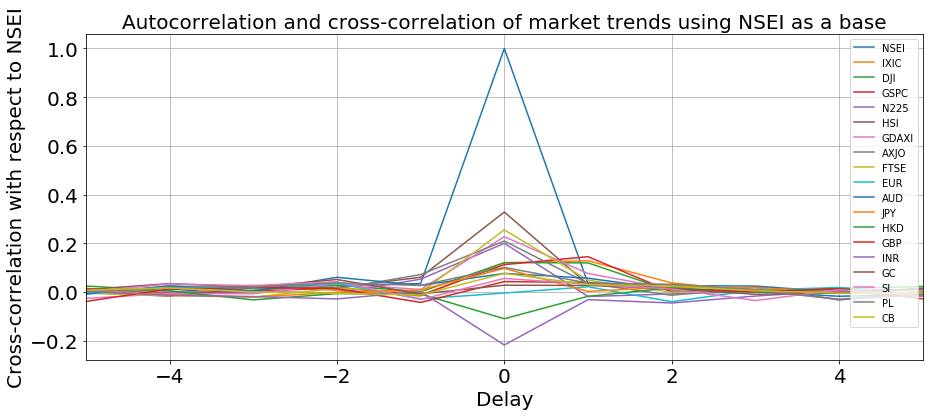

In [52]:
df3 = delta_day_return(df2,1)
df3 = df3.div(abs(df3))
df3.dropna(inplace=True)
corr_df = cross_corr(df3[analysis_symbol], df3, -5, 5)
corr_df.plot()
plt.grid()
plt.ylabel('Cross-correlation with respect to {}'.format(analysis_symbol), fontsize=20)
plt.xlabel('Delay', fontsize=20)
plt.title('Autocorrelation and cross-correlation of market trends using {} as a base'.format(analysis_symbol),
          fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

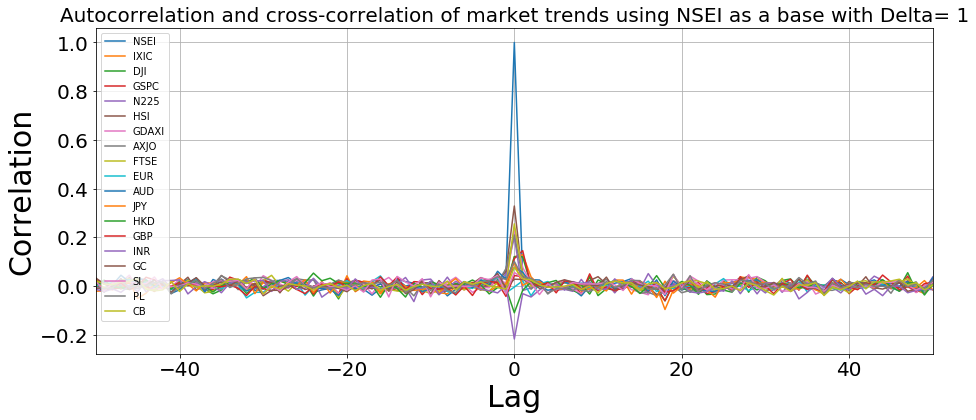

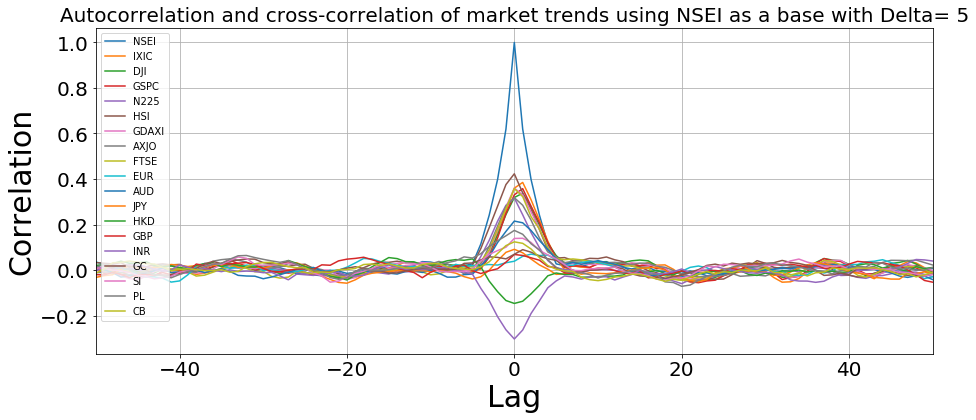

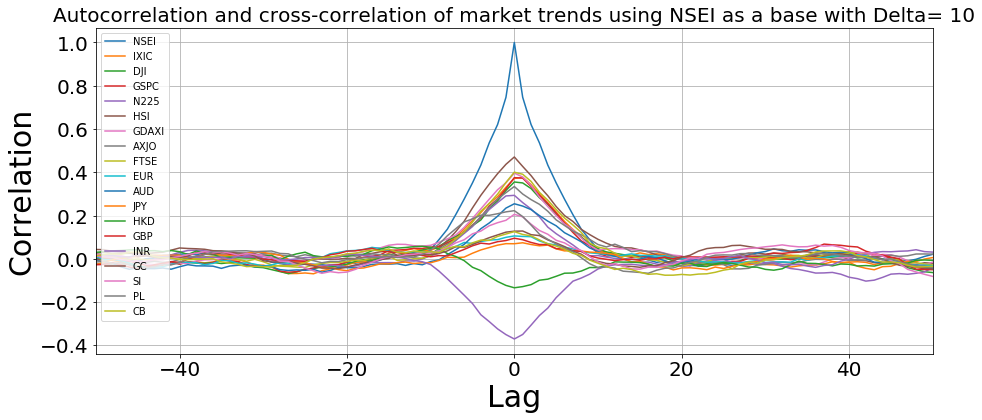

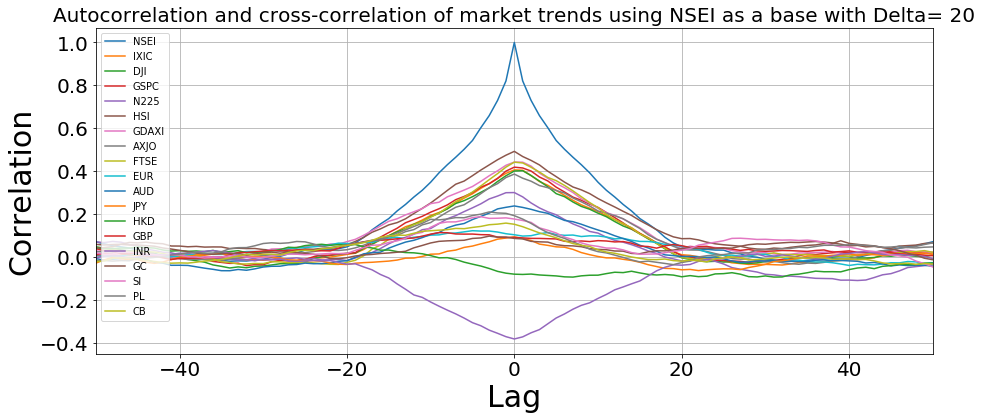

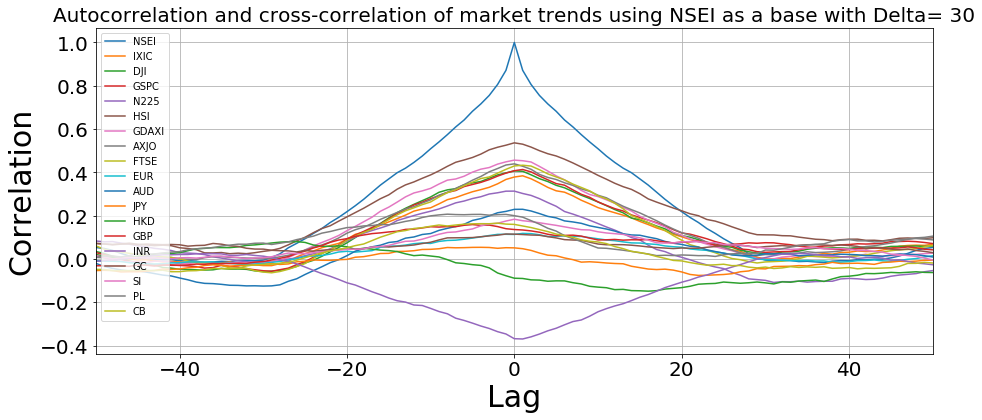

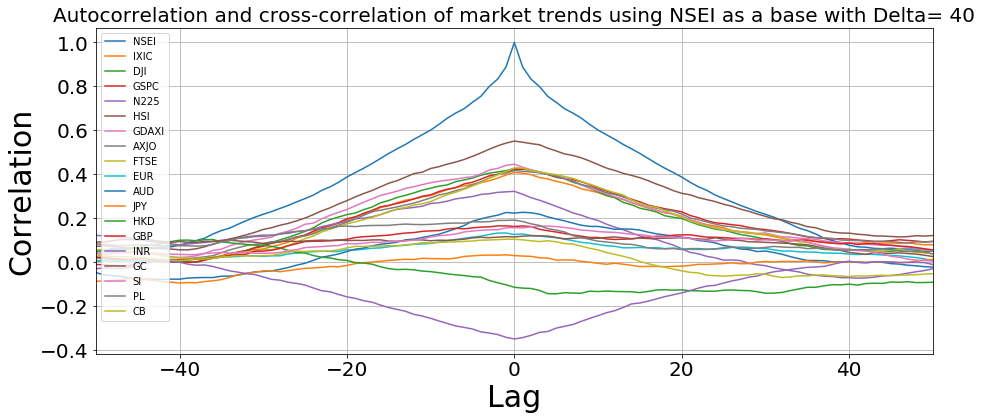

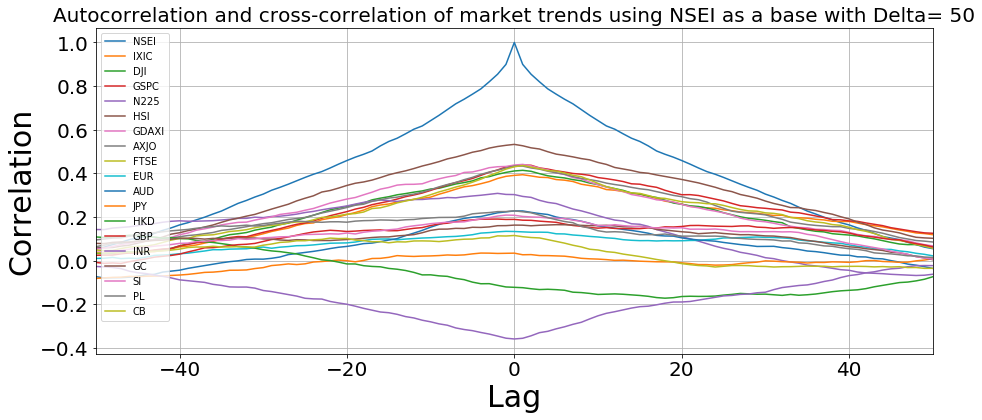

In [53]:
delta_list = [1,5,10,20,30,40,50]
for delta in delta_list:
    df6 = delta_day_return(df2,delta)
    df6 = df6.div(abs(df6))
    df6.dropna(inplace=True)
    corr_df = cross_corr(df6[analysis_symbol], df6, -50, 50)
    corr_df.plot()
    plt.grid()
    plt.ylabel('Correlation', fontsize=30)
    plt.xlabel('Lag', fontsize=30)
    plt.title('Autocorrelation and cross-correlation of market trends using {0} as a base with Delta= {1}'
              .format(analysis_symbol, str(delta)), fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(loc='upper left')

## Trend Prediction using Single Feature

In [54]:
print(__doc__)

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
# n_samples = all_features_df.shape[0]
X1 = df3[['GDAXI']]
y1 = df3[analysis_symbol]

# Split the dataset in two equal parts
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X1_train, y1_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y1_test, clf.predict(X1_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 0.001}

Grid scores on development set:

0.608 (+/-0.041) for {'C': 0.001}
0.608 (+/-0.041) for {'C': 0.01}
0.608 (+/-0.041) for {'C': 0.1}
0.608 (+/-0.041) for {'C': 1}
0.608 (+/-0.041) for {'C': 10}
0.608 (+/-0.041) for {'C': 100}
0.608 (+/-0.041) for {'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

        -1.0       0.59      0.59      0.59       687
         1.0       0.65      0.65      0.65       807

    accuracy                           0.62      1494
   macro avg       0.62      0.62      0.62      1494
weighted avg       0.62      0.62      0.62      1494


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.001}

Grid scores

/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

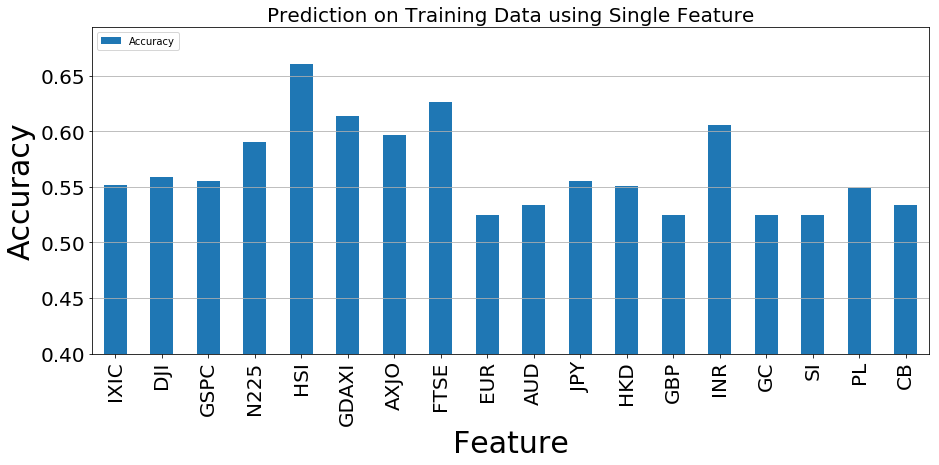

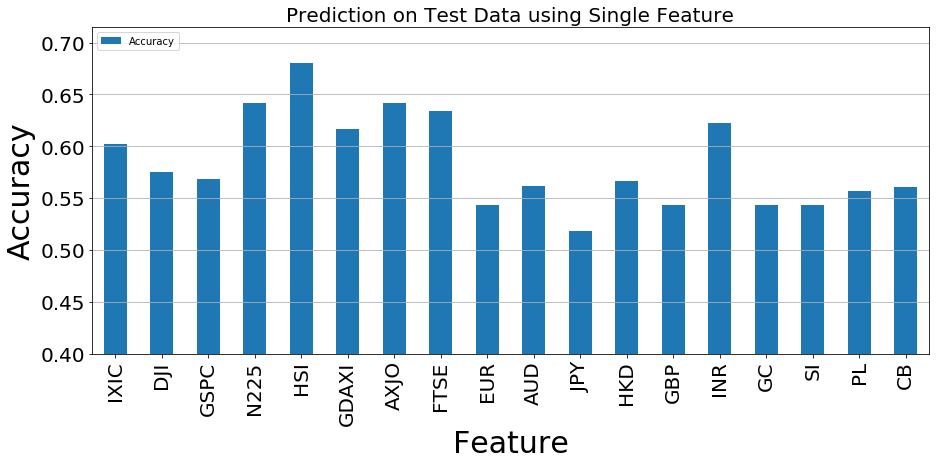

In [55]:
df7 = df2.copy()
df7.dropna(inplace=True)
df7 = delta_day_return(df7,1)
df7 = df7.div(abs(df7))
df7.dropna(inplace=True)
# df7['NSEI'] = df7['NSEI'].map(lambda x: 1 if(x>=0) else 0)
train_df, test_df = train_test_split(df7, test_size=0.2)
train_acc = []
test_acc = []
for col in train_df.columns:
    if(col != analysis_symbol):
        classifier = LogisticRegression(solver='warn', C=1, random_state=0)
        classifier.fit(train_df[[col]], train_df[analysis_symbol])
        train_acc.append((col, classifier.score(train_df[[col]], train_df[analysis_symbol])))
        test_acc.append((col, classifier.score(test_df[[col]], test_df[analysis_symbol])))
    
train_acc_df = pd.DataFrame(train_acc, columns=['Feature', 'Accuracy'])
train_acc_df.set_index('Feature', inplace=True)
ax = train_acc_df.plot.bar()
ax.yaxis.grid()
ax.set_ylim(bottom=0.4)
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Training Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

test_acc_df = pd.DataFrame(test_acc, columns=['Feature', 'Accuracy'])
test_acc_df.set_index('Feature', inplace=True)
ax = test_acc_df.plot.bar()
ax.yaxis.grid()
ax.set_ylim(bottom=0.4)
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Test Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

In [56]:
classifier

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
sum(train_df[analysis_symbol]==1)/len(train_df[analysis_symbol]) # Fraction of positive movements in training data (same as training acc)

0.5246861924686193

In [58]:
cm = confusion_matrix(test_df[analysis_symbol], classifier.predict(test_df[['HSI']]))
print(cm)

[[182  91]
 [100 225]]


/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

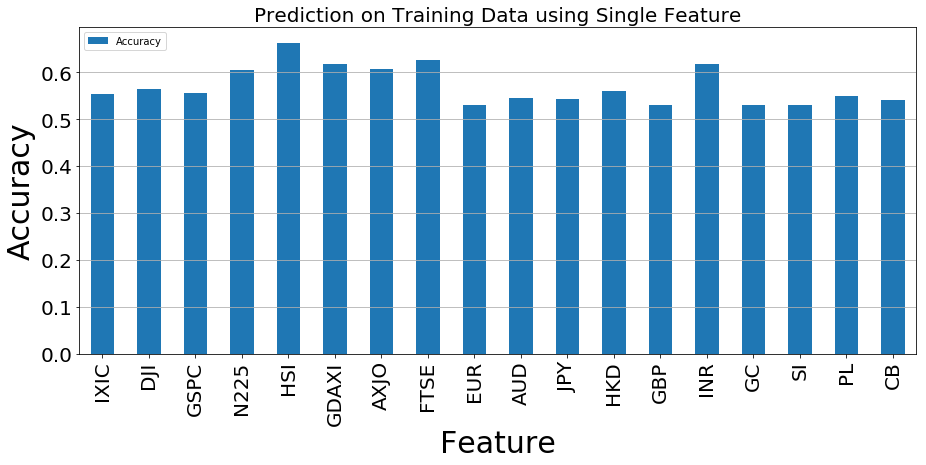

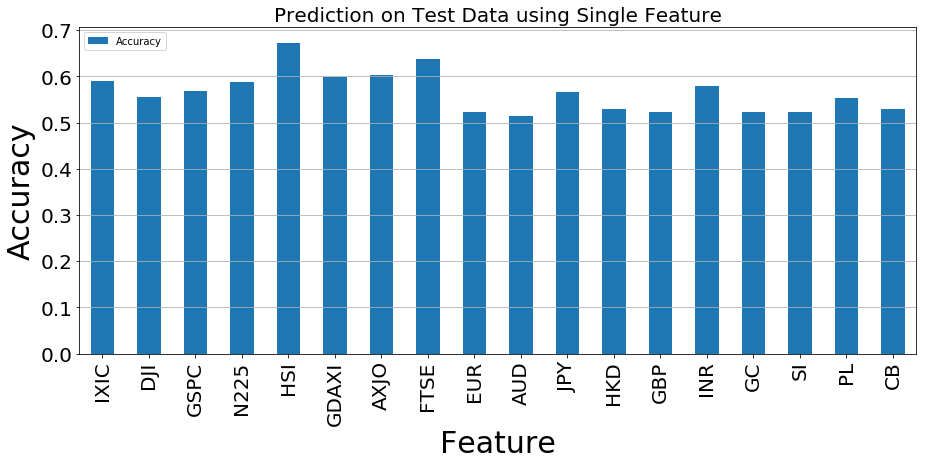

In [59]:
df7 = df2.copy()
df7.dropna(inplace=True)
df7 = delta_day_return(df7,1)
df7 = df7.div(abs(df7))
df7.dropna(inplace=True)
# df7['NSEI'] = df7['NSEI'].map(lambda x: 1 if(x>=0) else 0)
train_df, test_df = train_test_split(df7, test_size=0.2)
train_acc = []
test_acc = []
for col in train_df.columns:
    if(col != analysis_symbol):
        classifier = LogisticRegression(solver='warn', C=100, random_state=0)
        classifier.fit(train_df[[col]], train_df[analysis_symbol])
        train_acc.append((col, classifier.score(train_df[[col]], train_df[analysis_symbol])))
        test_acc.append((col, classifier.score(test_df[[col]], test_df[analysis_symbol])))
    
train_acc_df = pd.DataFrame(train_acc, columns=['Feature', 'Accuracy'])
train_acc_df.set_index('Feature', inplace=True)
ax = train_acc_df.plot.bar()
ax.yaxis.grid()
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Training Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

test_acc_df = pd.DataFrame(test_acc, columns=['Feature', 'Accuracy'])
test_acc_df.set_index('Feature', inplace=True)
ax = test_acc_df.plot.bar()
ax.yaxis.grid()
plt.ylabel('Accuracy', fontsize=30)
plt.xlabel('Feature', fontsize=30)
plt.title('Prediction on Test Data using Single Feature', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(loc='upper left')

In [60]:
classifier

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Multi Feature Prediction

In [61]:
unavailable_lagged_df = df2[unavailable_col_list].shift(1)
unavailable_lagged_df.columns = [col + "_1" for col in unavailable_lagged_df]
all_df_list = [df2[available_col_list], unavailable_lagged_df]
df_t = pd.concat(all_df_list, axis=1)
df_t.dropna(inplace=True)

In [116]:
delta_list = [1,5,10,20,30,40,50]
target = delta_day_return(df2[[analysis_symbol]],1)
target = target.div(abs(target))

features_df_list = [target]
for delta in delta_list:
    df7 = delta_day_return(df_t,delta)
    df7 = df7.div(abs(df7))
    df7.columns = [x + '_d' + str(delta) for x in df7.columns]
    features_df_list.append(df7)
all_features_df = pd.concat(features_df_list, axis=1)
all_features_df.dropna(inplace=True)
all_features_df.index = [x.date() for x in all_features_df.index]

In [117]:
train_df, test_df = train_test_split(all_features_df, test_size=0.2, random_state=0)

d1_col_list = [col for col in train_df.columns if(col[-3:]=="_d1")]
all_features_col_list = [col for col in train_df.columns if(col!=analysis_symbol)]
X_d1_train = train_df[d1_col_list]
X_train = train_df[all_features_col_list]
y_train = train_df[analysis_symbol]

X_d1_test = test_df[d1_col_list]
X_test = test_df[all_features_col_list]
y_test = test_df[analysis_symbol]

## Prediction using SVM
#### Using SVM on Features with lag=1

In [64]:
print(__doc__)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='%s_macro' % score)
    clf.fit(X_d1_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_d1_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/abhi/anaconda3/li

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.678 (+/-0.045) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.265 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.046) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.677 (+/-0.047) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.046) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.679 (+/-0.046) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.673 (+/-0.044) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.679 (+/-0.046) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.679 (+/-0.046) for {'C': 1, 'kernel': 'linear'}
0.679 (+/-0.046) for {'C': 10, 'kernel': 'linear'}
0.679 (+/-0.046) for {'C': 100, 'kernel': 'linear'}
0.679 (+/-0.046) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             

In [65]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_d1_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_d1_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, clf.predict(X_d1_train)))))

cm_test = confusion_matrix(y_test, clf.predict(X_d1_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, clf.predict(X_d1_test)))))

Train Confusion Matrix:
[[579 289]
 [302 676]]
Train Accuracy: 0.6798483206933911

Test Confusion Matrix:
[[141  78]
 [ 91 152]]
Test Accuracy: 0.6341991341991342


In [66]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

#### Using SVM on Features with all lag values (1,5,10,20,30,40,50)

In [67]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, clf.predict(X_train)))))

cm_test = confusion_matrix(y_test, clf.predict(X_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, clf.predict(X_test)))))

Train Confusion Matrix:
[[579 289]
 [302 676]]
Train Accuracy: 0.6798483206933911

Test Confusion Matrix:
[[141  78]
 [ 91 152]]
Test Accuracy: 0.6341991341991342


In [68]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

## Prediction using LightGBM
#### Using LightGBM on Features with lag=1

In [69]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 10
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_d1_train, label=y_train), 1000)
d1_train_pred = np.where(clf.predict(X_d1_train)>=thres, 1, -1)
d1_test_pred = np.where(clf.predict(X_d1_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, d1_train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, d1_train_pred))))

cm_test = confusion_matrix(y_test, d1_test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, d1_test_pred))))

Train Confusion Matrix:
[[575 293]
 [226 752]]
Train Accuracy: 0.718851570964247

Test Confusion Matrix:
[[133  86]
 [ 81 162]]
Test Accuracy: 0.6385281385281385


#### Using LightGBM on features with all lags

In [70]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_train, label=y_train), 1000)
train_pred = np.where(clf.predict(X_train)>=thres, 1, -1)
test_pred = np.where(clf.predict(X_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(str(accuracy_score(y_train, train_pred))))

cm_test = confusion_matrix(y_test, test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(str(accuracy_score(y_test, test_pred))))

Train Confusion Matrix:
[[605 263]
 [180 798]]
Train Accuracy: 0.7600216684723727

Test Confusion Matrix:
[[133  86]
 [ 80 163]]
Test Accuracy: 0.6406926406926406


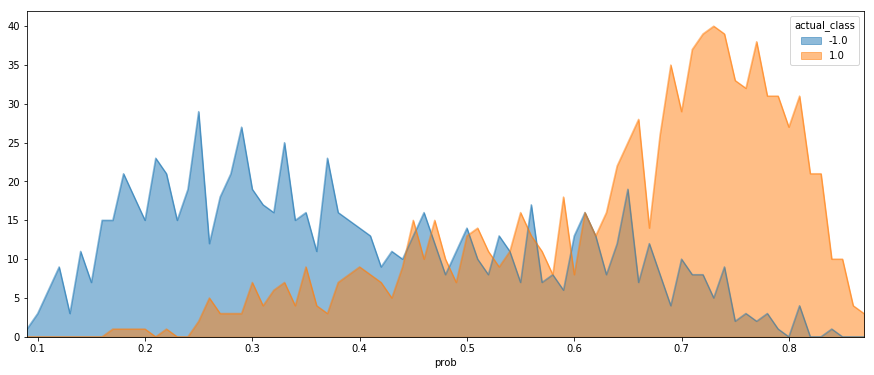

In [71]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_train.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_train).round(2))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

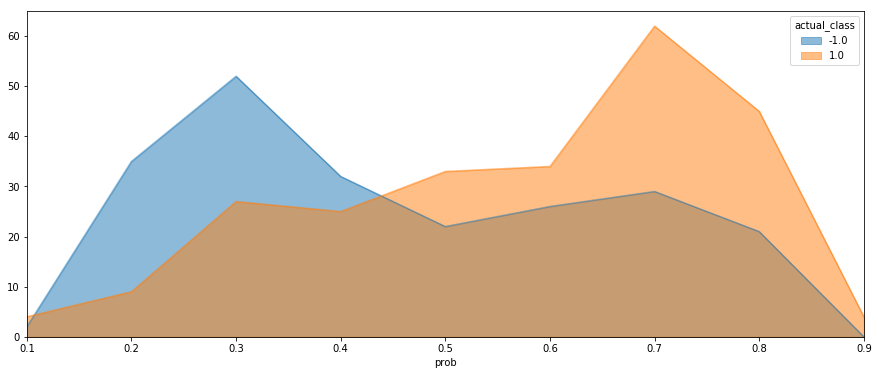

In [72]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_test.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_test).round(1))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

## Feature Selection

In [73]:
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(solver='lbfgs'),
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'accuracy',
           cv = 5)

sfs.fit(X_train, y_train)
sfs.k_feature_names_

('N225_d1',
 'HSI_d1',
 'AXJO_d1',
 'GBP_1_d5',
 'EUR_1_d10',
 'AUD_d20',
 'IXIC_1_d20',
 'GSPC_1_d20',
 'INR_1_d30',
 'SI_d40')

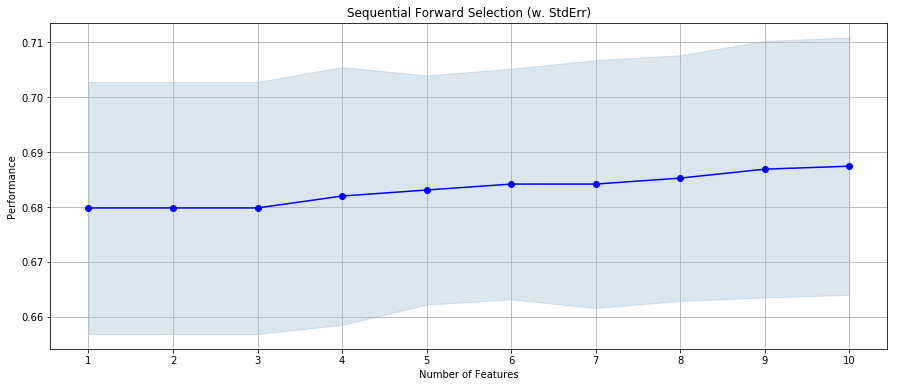

In [74]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [75]:
X_selected_features_train = X_train[list(sfs.k_feature_names_[:5])]
X_selected_features_test = X_test[list(sfs.k_feature_names_[:5])]

### SVM on selected Features

In [76]:
clf = SVC(C= 10, kernel='linear')
clf.fit(X_selected_features_train, y_train)

cm_train = confusion_matrix(y_train, clf.predict(X_selected_features_train))
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(accuracy_score(y_train, clf.predict(X_selected_features_train))))

cm_test = confusion_matrix(y_test, clf.predict(X_selected_features_test))
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(accuracy_score(y_test, clf.predict(X_selected_features_test))))

Train Confusion Matrix:
[[579 289]
 [302 676]]
Train Accuracy: 0.6798483206933911

Test Confusion Matrix:
[[141  78]
 [ 91 152]]
Test Accuracy: 0.6341991341991342


### LightGBM on selected Features

In [77]:
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 10
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5
clf = lgb.train(params, lgb.Dataset(X_selected_features_train, label=y_train), 1000)
train_pred = np.where(clf.predict(X_selected_features_train)>=thres, 1, -1)
test_pred = np.where(clf.predict(X_selected_features_test)>=thres, 1, -1)

cm_train = confusion_matrix(y_train, train_pred)
print('Train Confusion Matrix:')
print(cm_train)
print('Train Accuracy: {}\n'.format(accuracy_score(y_train, train_pred)))

cm_test = confusion_matrix(y_test, test_pred)
print('Test Confusion Matrix:')
print(cm_test)
print('Test Accuracy: {}'.format(accuracy_score(y_test, test_pred)))

Train Confusion Matrix:
[[541 327]
 [261 717]]
Train Accuracy: 0.6814734561213435

Test Confusion Matrix:
[[132  87]
 [ 77 166]]
Test Accuracy: 0.645021645021645


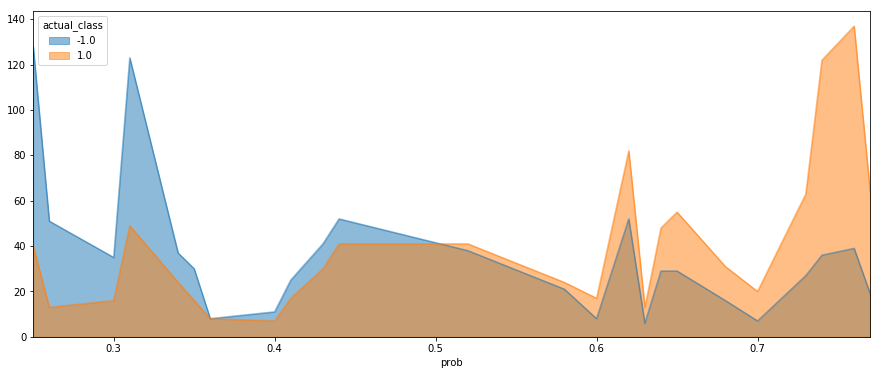

In [78]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_train.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_selected_features_train).round(2))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

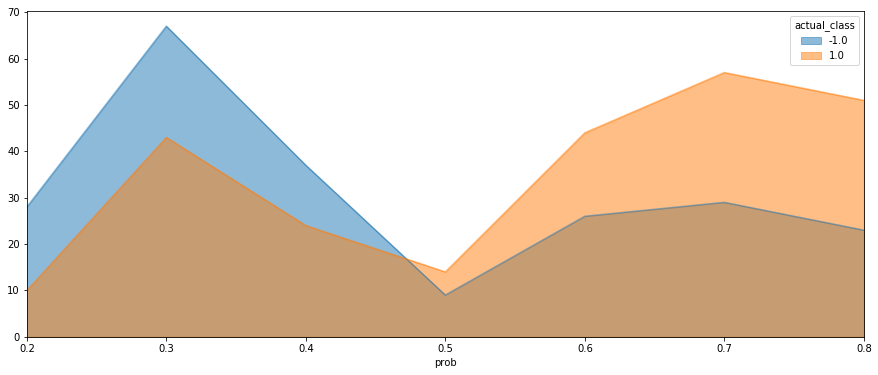

In [92]:
hist_df = pd.DataFrame()
hist_df["actual_class"] = y_test.tolist()
hist_df["prob"] = pd.Series(clf.predict(X_selected_features_test).round(1))
hist_df["count"] = 1
hist_df = hist_df.pivot_table(index="prob", columns="actual_class", values="count", aggfunc="sum")
hist_df.plot(kind="area", stacked=False)

## Use of continuous re-training for actual prediction

In [126]:
def select_top_k_features(X_train, y_train, k=10):
    # Sequential Forward Selection(sfs)
    sfs = SFS(LogisticRegression(solver='lbfgs'),
               k_features=k,
               forward=True,
               floating=False,
               scoring = 'accuracy',
               cv = 5)

    sfs.fit(X_train, y_train)
    return(list(sfs.k_feature_names_))

In [165]:
## Analysis Parameters
backtest_st_dt = datetime(2010,1,1).date()
retrain_period = relativedelta(months=+1)
training_lookback_period = relativedelta(months=+10*12)
num_features = 5

## Model Parameters
thres = 0.5

params = {}
params['learning_rate'] = 0.005
params['lambda'] = 10
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['feature_fraction'] = 0.8
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 5

## Run backtest
test_st_dt = backtest_st_dt
max_dt_in_data = all_features_df.index.max()
# max_dt_in_data = datetime(2010,5,31).date()
all_features_col_list = [col for col in all_features_df.columns if(col!=analysis_symbol)]
predictions_df_list = []

while(test_st_dt <= max_dt_in_data):
    test_end_dt = test_st_dt + retrain_period - timedelta(days=1)
    train_st_dt = test_st_dt - training_lookback_period - timedelta(days=1)
    train_end_dt = test_st_dt - timedelta(days=1)
    
    train_df = copy.deepcopy(all_features_df[(all_features_df.index>=train_st_dt) &
                                             (all_features_df.index<=train_end_dt)])
    test_df = copy.deepcopy(all_features_df[(all_features_df.index>=test_st_dt) &
                                            (all_features_df.index<=test_end_dt)])
    
    X_train_all = train_df[all_features_col_list]
    y_train = train_df[analysis_symbol]
    selected_features_list = select_top_k_features(X_train_all, y_train, num_features)
    print("selected features dates {0} - {1} are: {2}".format(test_st_dt, test_end_dt,
                                                                            selected_features_list))
    
    X_train = train_df[selected_features_list]
    X_test = test_df[selected_features_list]
    y_test = test_df[analysis_symbol]
    
    clf = lgb.train(params, lgb.Dataset(X_train, label=y_train), 1000)
    
    if(test_st_dt == backtest_st_dt):
        train_pred_prob = clf.predict(X_train)
        train_pred = np.where(train_pred_prob>=thres, 1, -1)
        train_pred_df = pd.DataFrame(y_train.tolist(), index=y_train.index, columns=["Actual"])
        train_pred_df["Predicted Probability"] = train_pred_prob.round(2)
        train_pred_df["Predicted Class"] = train_pred
        predictions_df_list.append(train_pred_df)
    
    test_pred_prob = clf.predict(X_test)
    test_pred = np.where(test_pred_prob>=thres, 1, -1)
    
    test_pred_df = pd.DataFrame(y_test.tolist(), index=y_test.index, columns=["Actual"])
    test_pred_df["Predicted Probability"] = test_pred_prob.round(2)
    test_pred_df["Predicted Class"] = test_pred
    predictions_df_list.append(test_pred_df)
    
    test_st_dt = test_st_dt + retrain_period
    
predictions_df = pd.concat(predictions_df_list)

selected features dates 2010-01-01 - 2010-01-31 are: ['HSI_d1', 'AXJO_d1', 'GSPC_1_d10', 'IXIC_1_d40', 'DJI_1_d50']
selected features dates 2010-02-01 - 2010-02-28 are: ['N225_d1', 'HSI_d1', 'AXJO_d5', 'GSPC_1_d10', 'IXIC_1_d20']
selected features dates 2010-03-01 - 2010-03-31 are: ['HSI_d1', 'AXJO_d1', 'HSI_d5', 'IXIC_1_d10', 'N225_d40']
selected features dates 2010-04-01 - 2010-04-30 are: ['HSI_d1', 'AXJO_d1', 'NSEI_1_d1', 'AXJO_d10', 'DJI_1_d20']
selected features dates 2010-05-01 - 2010-05-31 are: ['HSI_d1', 'AXJO_d1', 'N225_d5', 'GSPC_1_d10', 'EUR_1_d10']
selected features dates 2010-06-01 - 2010-06-30 are: ['HSI_d1', 'AXJO_d1', 'GBP_1_d5', 'AXJO_d10', 'DJI_1_d20']
selected features dates 2010-07-01 - 2010-07-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'AXJO_d5', 'PL_d30']
selected features dates 2010-08-01 - 2010-08-31 are: ['HSI_d1', 'AXJO_d1', 'HSI_d5', 'AUD_d30', 'IXIC_1_d40']
selected features dates 2010-09-01 - 2010-09-30 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'AXJO_d5', 'HKD_d2

selected features dates 2016-05-01 - 2016-05-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'HKD_d1', 'JPY_d5']
selected features dates 2016-06-01 - 2016-06-30 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'JPY_d1', 'HKD_d1']
selected features dates 2016-07-01 - 2016-07-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'JPY_d1', 'DJI_1_d50']
selected features dates 2016-08-01 - 2016-08-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'JPY_d1', 'NSEI_1_d10']
selected features dates 2016-09-01 - 2016-09-30 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'JPY_d1', 'N225_d10']
selected features dates 2016-10-01 - 2016-10-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'JPY_d1', 'N225_d5']
selected features dates 2016-11-01 - 2016-11-30 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'JPY_d1', 'JPY_d5']
selected features dates 2016-12-01 - 2016-12-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'HKD_d1', 'GDAXI_1_d30']
selected features dates 2017-01-01 - 2017-01-31 are: ['N225_d1', 'HSI_d1', 'AXJO_d1', 'AUD_d1', 'DJI_1_d40']
selected features dates 2017

In [172]:
train_prediction_df = predictions_df[predictions_df.index<backtest_st_dt]
cm_test = confusion_matrix(train_prediction_df["Actual"], train_prediction_df["Predicted Class"])
print('Back Test Confusion Matrix:')
print(cm_test)
print('Back Test Accuracy: {}'.format(accuracy_score(train_prediction_df["Actual"],
                                                     train_prediction_df["Predicted Class"])))

Back Test Confusion Matrix:
[[273 179]
 [137 417]]
Back Test Accuracy: 0.6858846918489065


In [167]:
backtest_prediction_df = predictions_df[predictions_df.index>=backtest_st_dt]
cm_test = confusion_matrix(backtest_prediction_df["Actual"], backtest_prediction_df["Predicted Class"])
print('Back Test Confusion Matrix:')
print(cm_test)
print('Back Test Accuracy: {}'.format(accuracy_score(backtest_prediction_df["Actual"],
                                                     backtest_prediction_df["Predicted Class"])))

Back Test Confusion Matrix:
[[370 265]
 [175 492]]
Back Test Accuracy: 0.6620583717357911


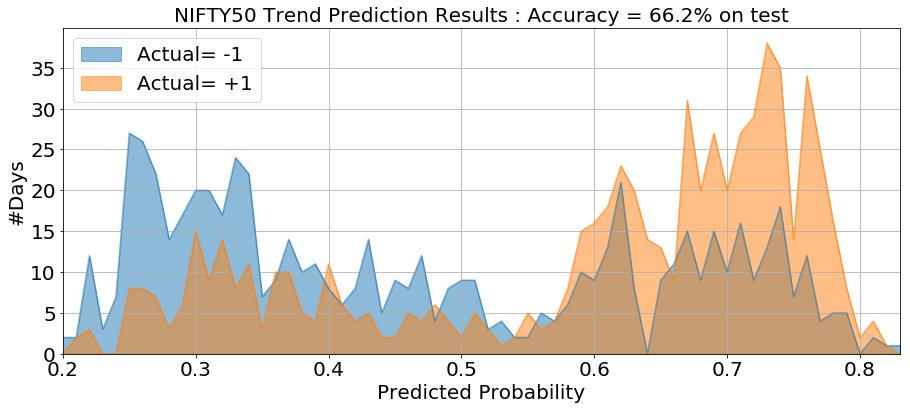

In [209]:
hist_df = backtest_prediction_df.pivot_table(index="Predicted Probability", columns="Actual", values=None,
                                             aggfunc="count")
hist_df.columns = ["Actual= -1", "Actual= +1"]
hist_df.plot(kind="area", stacked=False)
plt.ylabel("#Days", fontsize=20)
plt.xlabel("Predicted Probability", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("NIFTY50 Trend Prediction Results : Accuracy = 66.2% on test", fontsize=20)
plt.legend(fontsize=20)
plt.grid()

## Get BackTest Performance Report

In [185]:
req_col_list = ["Open", "Close"]

df = pd.read_csv(input_data_path + nifty50_fnm[0][1])
df['Date'] = pd.to_datetime(df['Date'], format='%d %b %Y').map(lambda x: x.date())
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

for col in req_col_list:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
df = df[req_col_list]
df1 = pd.merge(df, predictions_df, how="inner", left_index=True, right_index=True)
df1.index = pd.to_datetime(df1.index)


df1["Return"] = (df1["Close"]-df1["Open"])*df1["Predicted Class"]/df1["Open"]

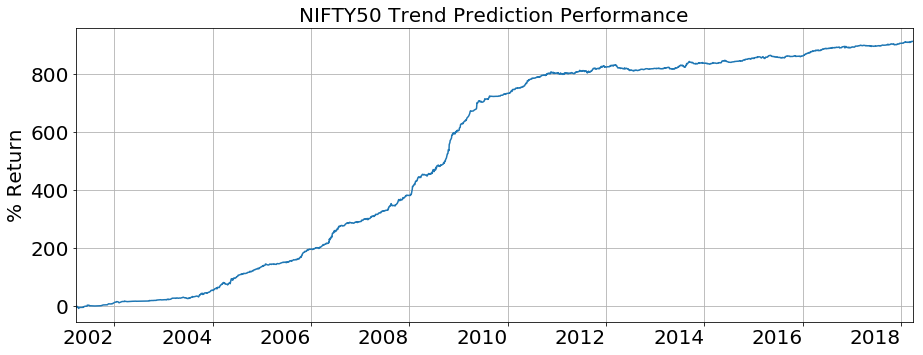

In [204]:
pnl_df = df1["Return"]*100
pnl_df.cumsum().plot(rot=0)
plt.ylabel("% Return", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title("NIFTY50 Trend Prediction Performance", fontsize=20)
plt.grid()

/Users/abhi/anaconda3/lib/python3.6/site-packages/pyfolio/tears.py:514: UserWarning: The latest version of pyfolio requires users to supply benchmark returns. Your current tearsheets will not include plots and analyses that require a benchmark. In the future, please pass benchmark_rets, or pass None to silence this warning.
  warnings.warn(BENCHMARK_RETS_WARNING)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.85,2012-03-09,2012-07-26,2013-08-21,379
1,9.31,2013-09-11,2014-02-10,2014-05-12,174
2,8.90,2015-05-08,2015-07-23,2016-01-12,178
3,8.82,2010-11-19,2011-02-10,2011-06-14,148
4,8.61,2011-06-20,2011-08-16,2011-09-22,69


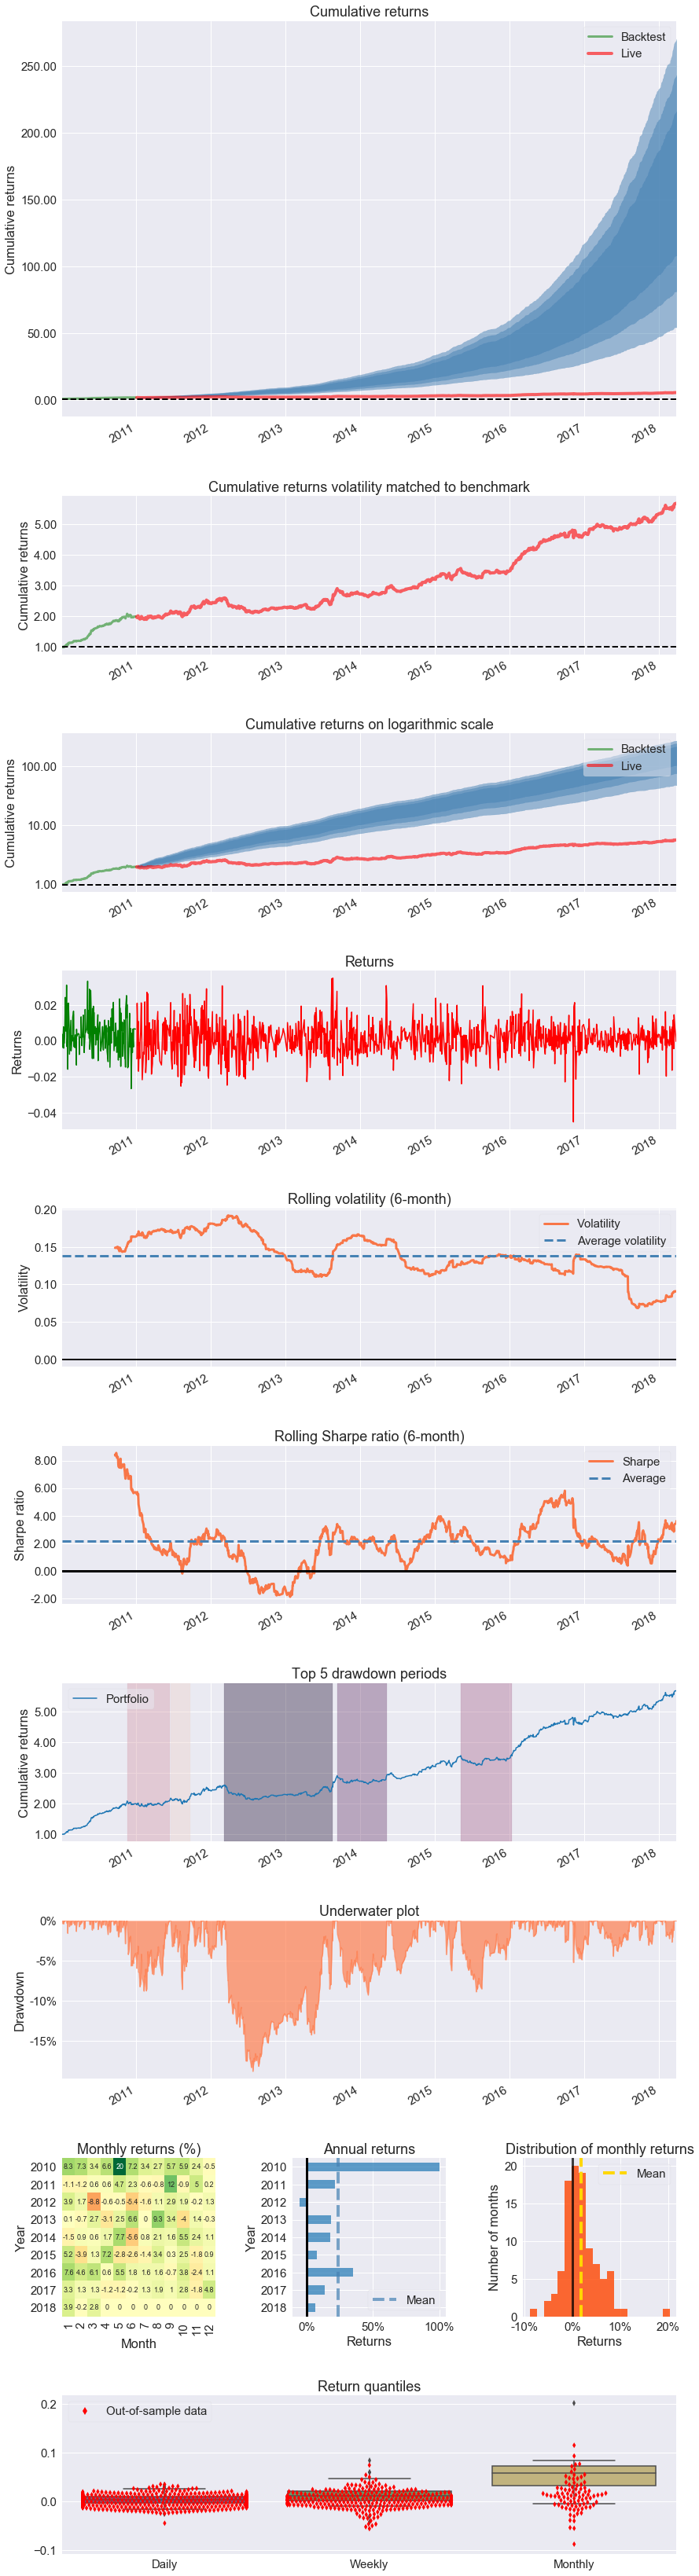

In [197]:
returns = df1[df1.index >= datetime.combine(backtest_st_dt, datetime.min.time())]["Return"]
pf.create_returns_tear_sheet(returns, live_start_date = '2011-1-1')